## <font color = 'black'> Importing Necessary Libraries

# Pairs Trading
Pairs Trading is a market-neutral trading strategy which involves matching a long position with a short position in two securities which have a high level of positive cointegration. It is a form of statistical arbitrage i.e it looks at the relative price movement between the two securities.

As it is a market-neutral strategy, it is independent of the trend being followed by the overall market (upwards or downwards or sideways). Instead, pairs trading works on the concept of mean-reversion. When two highly cointegrated securites deviate from their general trend, it is expected that they will return back to that trend in the future.

The spread between the stock prices created during the deviation serves as an opportunity for profit. One can open a long position on the stock expected to move upwards and a short position on the stock expected to move downwards. If the pair performs as expected, it is a profitable trade.

Even if the pair does not perform as expected, the trader will be able to mitigate some portion of their losses as the loss on one security will be offset by the profits on the other security. Hence, pairs trading also acts as a form of hedging and can be used to minimise losses.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install yfinance
!pip install niftystocks
!pip install quantstats

import yfinance as yf
from niftystocks import ns
import statsmodels.api as sm
import quantstats as qs
from statsmodels.tsa.stattools import coint

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.4 MB/s eta 0:00:00


## <font color='black'>Fetching the Stock Price Data

In [2]:
# Collecting all tickers in nifty 100
tickers = ns.get_nifty100_with_ns()

In [3]:
# Fetching stock data for all tickers
stock_data = {}

start_date = "2017-06-01"
end_date = "2020-06-30"

for stock in tickers:
  ticker = yf.Ticker(stock)
  stock_data[stock] = ticker.history(start = start_date, end = end_date)['Close']

stock_prices = pd.DataFrame(stock_data)

ERROR:yfinance:$MOTHERSUMI.NS: possibly delisted; no timezone found
ERROR:yfinance:Could not get exchangeTimezoneName for ticker 'UPL.NS' reason: 'chart'
ERROR:yfinance:$UPL.NS: possibly delisted; no timezone found
ERROR:yfinance:$HDFC.NS: possibly delisted; no timezone found
ERROR:yfinance:$LTI.NS: possibly delisted; no timezone found
ERROR:yfinance:$CADILAHC.NS: possibly delisted; no timezone found
ERROR:yfinance:$ADANITRANS.NS: possibly delisted; no timezone found
ERROR:yfinance:$MCDOWELL-N.NS: possibly delisted; no timezone found


In [5]:
stock_prices.dropna(axis=1, inplace=True)
stock_prices.sort_index(inplace=True)
stock_prices

,HDFCBANK.NS,IGL.NS,IOC.NS,SHREECEM.NS,TATACONSUM.NS,TATAMOTORS.NS,ADANIPORTS.NS,AMBUJACEM.NS,DABUR.NS,GODREJCP.NS,...,VEDL.NS,BIOCON.NS,INDUSTOWER.NS,ITC.NS,JSWSTEEL.NS,LUPIN.NS,M&M.NS,MUTHOOTFIN.NS,PETRONET.NS,SUNPHARMA.NS
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-01 00:00:00+05:30,765.152893,94.277962,81.981552,17182.076172,139.575729,473.707214,333.933807,209.197372,264.007568,572.134155,...,85.275963,156.215561,277.333466,237.817551,173.252258,1094.620483,654.424377,357.488098,159.324646,471.431610
2017-06-02 00:00:00+05:30,767.807495,96.444618,82.169754,17478.802734,141.819580,475.794250,342.253479,209.284424,263.313782,573.284729,...,84.390930,158.566498,276.154083,241.602005,172.631744,1114.482788,651.325012,373.402618,160.385620,478.306366
2017-06-05 00:00:00+05:30,768.418274,96.169914,83.605919,18123.423828,141.911179,475.197937,345.265686,209.197372,264.423889,572.228760,...,84.593742,160.639908,281.903534,243.907043,168.864441,1104.074341,653.712708,378.111542,157.040878,476.401855
2017-06-06 00:00:00+05:30,770.015686,98.961281,84.111084,17661.890625,140.125275,458.153839,345.648193,204.584305,261.602020,572.890625,...,84.593742,161.880692,282.419464,238.989731,170.282730,1099.108765,648.087952,370.481354,161.878143,468.505157
2017-06-07 00:00:00+05:30,770.884888,98.026405,84.655823,17592.351562,142.460663,455.172363,343.401001,205.933426,262.573547,586.838684,...,85.995041,162.892899,282.456329,239.911697,173.207932,1102.403198,657.477905,382.994904,158.245682,475.240601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-23 00:00:00+05:30,1000.585632,206.164062,42.178684,22401.652344,378.801422,103.755447,346.915253,174.878021,438.687286,649.085449,...,49.280300,390.739868,201.805435,148.308990,187.440308,912.968079,489.365356,1053.423706,205.055984,475.925964
2020-06-24 00:00:00+05:30,991.177856,201.618515,41.116550,22214.611328,371.290314,104.152977,343.208618,170.760590,435.291382,655.674500,...,49.033897,384.235748,202.413422,153.097015,180.236435,896.906738,488.370270,1038.905396,207.425232,460.662445
2020-06-25 00:00:00+05:30,987.578003,202.345810,40.148823,21724.916016,372.162598,103.159149,335.551392,168.543488,439.213440,660.164795,...,49.840302,398.426544,198.418137,161.276535,179.911087,910.388550,480.694305,1031.483154,205.964203,463.753113


## <font color='black'> Finding Correlated Pairs (Pretest)

In [6]:
def find_correlated_pairs(df, threshold):

    corr_matrix = df.corr()
    n = corr_matrix.shape[0]
    result = pd.DataFrame(columns=['Asset 1', 'Asset 2', 'Correlation Coefficient'])

    for i in range(n):
        for j in range(i + 1, n):
            correlation = corr_matrix.iloc[i, j]
            if correlation >= threshold:
                result = pd.concat([result,
                                    pd.DataFrame({'Asset 1': [df.columns[i]],
                                                  'Asset 2': [df.columns[j]],
                                                  'Correlation Coefficient': [correlation]})],
                                   ignore_index=True)
    return result


In [7]:
corr_pairs = find_correlated_pairs(stock_prices, 0.9)
corr_pairs

,Asset 1,Asset 2,Correlation Coefficient
0,HDFCBANK.NS,BAJAJFINSV.NS,0.951987
1,HDFCBANK.NS,KOTAKBANK.NS,0.939886
2,HDFCBANK.NS,BAJFINANCE.NS,0.930653
3,TATAMOTORS.NS,PNB.NS,0.916492
4,DABUR.NS,HINDUNILVR.NS,0.938993
5,DABUR.NS,NESTLEIND.NS,0.900196
6,DABUR.NS,PIDILITIND.NS,0.904527
7,PGHH.NS,TITAN.NS,0.925651
8,HEROMOTOCO.NS,EICHERMOT.NS,0.915297
9,HEROMOTOCO.NS,VEDL.NS,0.910467


After performing correlation test with a threshold of 0.9, we have obtained 50 pairs of stocks out of 89*88/2 = 3916 possible pairs for further consideration.

## <font color='black'> Finding Cointegrated Pairs

In [8]:
def finding_cointegrated_pairs(df, threshold):

    result = []
    for i in range(len(df)):
        asset1 = df['Asset 1'][i]
        asset2 = df['Asset 2'][i]
        p_value = coint(stock_prices[asset1], stock_prices[asset2])[1]
        if p_value <= threshold:
            result.append({
                'Asset 1': asset1,
                'Asset 2': asset2,
                'Correlation': df['Correlation Coefficient'][i],
                'p-value': p_value
            })
    return pd.DataFrame(result)


In [9]:
coint_pairs = finding_cointegrated_pairs(corr_pairs, 0.01)
coint_pairs

,Asset 1,Asset 2,Correlation,p-value
0,PGHH.NS,TITAN.NS,0.925651,0.000843
1,HEROMOTOCO.NS,VEDL.NS,0.910467,0.005902
2,HINDUNILVR.NS,PIDILITIND.NS,0.948760,0.004872
3,GRASIM.NS,VEDL.NS,0.955442,0.008603
4,INFY.NS,TCS.NS,0.961574,0.000090
5,ONGC.NS,COALINDIA.NS,0.925352,0.005338
6,ONGC.NS,NTPC.NS,0.913341,0.001108
7,KOTAKBANK.NS,BAJFINANCE.NS,0.952266,0.002839
8,DIVISLAB.NS,TORNTPHARM.NS,0.936612,0.009933


After performing cointegration test with a threshold of 0.01, we have obtained 9 pairs of stocks out of 8 pairs for further consideration.

## <font color='black'>Calculating Hedge Ratios

In [10]:
def calculate_hedge_ratio(df):
    hedge_ratio = []
    n = df.shape[0]
    for i in range(n):
        covariance = np.cov(stock_prices[df.iloc[i, 0]], stock_prices[df.iloc[i, 1]])[0, 1]
        variance = np.var(stock_prices[df.iloc[i, 0]])
        hedge_ratio.append(covariance/variance)
    return hedge_ratio

In [11]:
coint_pairs['Hedge Ratio'] = calculate_hedge_ratio(coint_pairs)

To choose from remaining 9 pairs, we will choose the pair whose hedge ratio is nearest to 1

In [12]:
coint_pairs['criterion'] = np.abs(coint_pairs['Hedge Ratio'] - 1)
coint_pairs.sort_values(by='criterion', inplace=True)
coint_pairs

,Asset 1,Asset 2,Correlation,p-value,Hedge Ratio,criterion
5,ONGC.NS,COALINDIA.NS,0.925352,0.005338,1.000888,0.000888
2,HINDUNILVR.NS,PIDILITIND.NS,0.948760,0.004872,0.690501,0.309499
6,ONGC.NS,NTPC.NS,0.913341,0.001108,0.448586,0.551414
8,DIVISLAB.NS,TORNTPHARM.NS,0.936612,0.009933,0.334497,0.665503
0,PGHH.NS,TITAN.NS,0.925651,0.000843,0.198924,0.801076
3,GRASIM.NS,VEDL.NS,0.955442,0.008603,0.128576,0.871424
1,HEROMOTOCO.NS,VEDL.NS,0.910467,0.005902,0.055760,0.944240
4,INFY.NS,TCS.NS,0.961574,0.000090,3.069432,2.069432
7,KOTAKBANK.NS,BAJFINANCE.NS,0.952266,0.002839,3.809985,2.809985


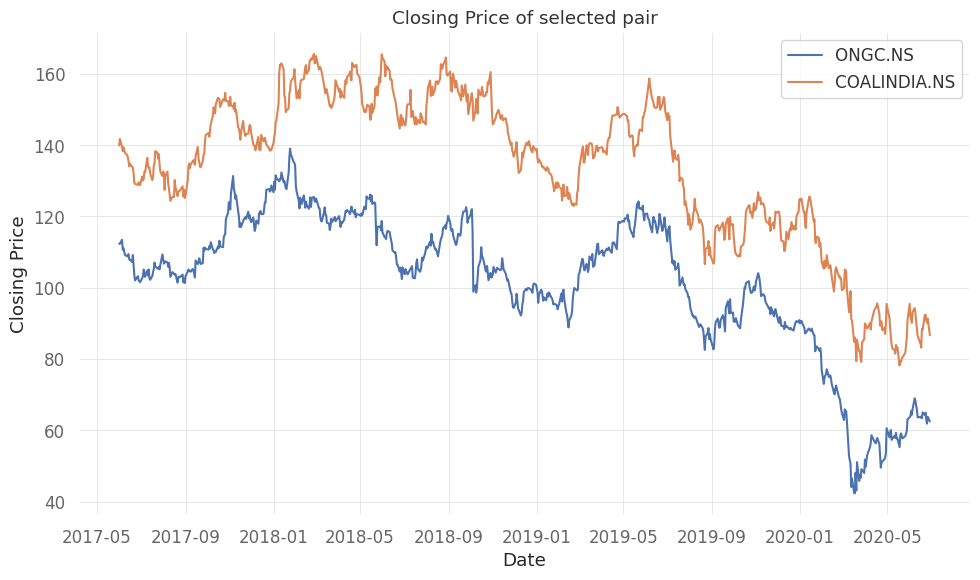

In [13]:
sns.lineplot(stock_prices[coint_pairs.iloc[0, 0]], label=coint_pairs.iloc[0, 0])
sns.lineplot(stock_prices[coint_pairs.iloc[0, 1]], label=coint_pairs.iloc[0, 1])
plt.title('Closing Price of selected pair')
plt.ylabel('Closing Price')
plt.xlabel('Date')
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

## <font color='black'>Selected Pair of Stocks

In [14]:
stock1 = coint_pairs.iloc[0, 1]
stock2 = coint_pairs.iloc[0, 0]
hedge_ratio = coint_pairs.iloc[1, 4]
print(stock1, stock2, hedge_ratio)

COALINDIA.NS ONGC.NS 0.6905010963389767


In [15]:
startdate = "2020-07-01"
enddate = "2023-07-31"

stockprices = yf.download([stock1, stock2], start=startdate, end=enddate)['Close']

[*********************100%***********************]  2 of 2 completed


In [16]:
stockprices

Ticker,COALINDIA.NS,ONGC.NS
Date,,
2020-07-01,86.038887,61.022701
2020-07-02,85.878189,62.084618
2020-07-03,86.938805,62.501816
2020-07-06,87.324501,63.525795
2020-07-07,85.396095,62.160480
...,...,...
2023-07-24,201.895905,154.956512
2023-07-25,201.021729,156.768875
2023-07-26,201.502533,156.723557


### <font color='black'> Calculating spread

In [17]:
spread = -stockprices[stock1]*hedge_ratio + stockprices[stock2]

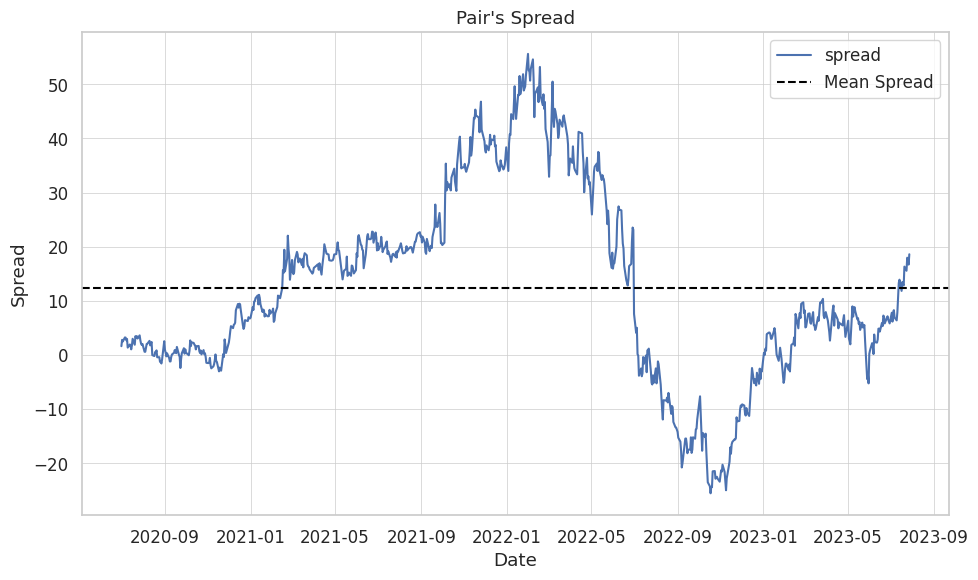

In [18]:
sns.lineplot(spread, label='spread')
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean Spread')
plt.title("Pair's Spread")
plt.ylabel('Spread')
plt.xlabel('Date')
sns.set_style('whitegrid')
plt.legend()
plt.tight_layout()
plt.show()

### <font color='black'>Calculating z-score

In [19]:
def zscore(series):
    lookback = 21
    scores = []
    for i in range(lookback, len(series)):
      window = series[i-lookback:i]
      scores.append((series[i]-window.mean())/window.std())
    return pd.Series(scores, index = series.index[lookback:])

In [20]:
zscore = zscore(spread)

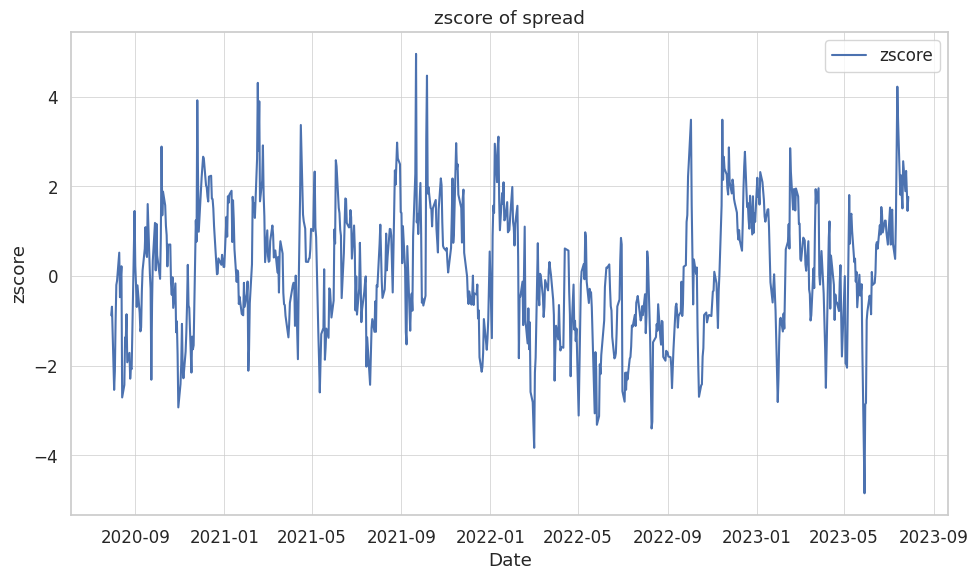

In [21]:
sns.lineplot(zscore, label = 'zscore')
plt.title("zscore of spread")
plt.ylabel('zscore')
plt.xlabel('Date')
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

## <font color='black'>Trading Strategy

### <font color='black'>Generation of Signals

In [22]:
# Create a dataframe for trading signals
signals = pd.DataFrame()
signals[stock1] = stockprices[stock1]
signals[stock2] = stockprices[stock2]
signals['spread'] = spread
signals['zscore'] = zscore

signals.dropna(inplace = True)

signals['signal1'] = np.select([signals['zscore'] > 1, signals['zscore'] < -1], [1, -1], default = 0)
signals['position1'] = 0

signals['position1'] = signals['signal1'].diff()
if signals['signal1'][0] != 0:
    signals['position1'][0] = signals['signal1'][0]
signals['signal2'] = -signals['signal1']
signals['position2'] = -signals['position1']

signals.dropna(inplace = True)
signals

signals.to_csv('signals.csv')

### <font color='black'>Visualizing Long and Short Positions

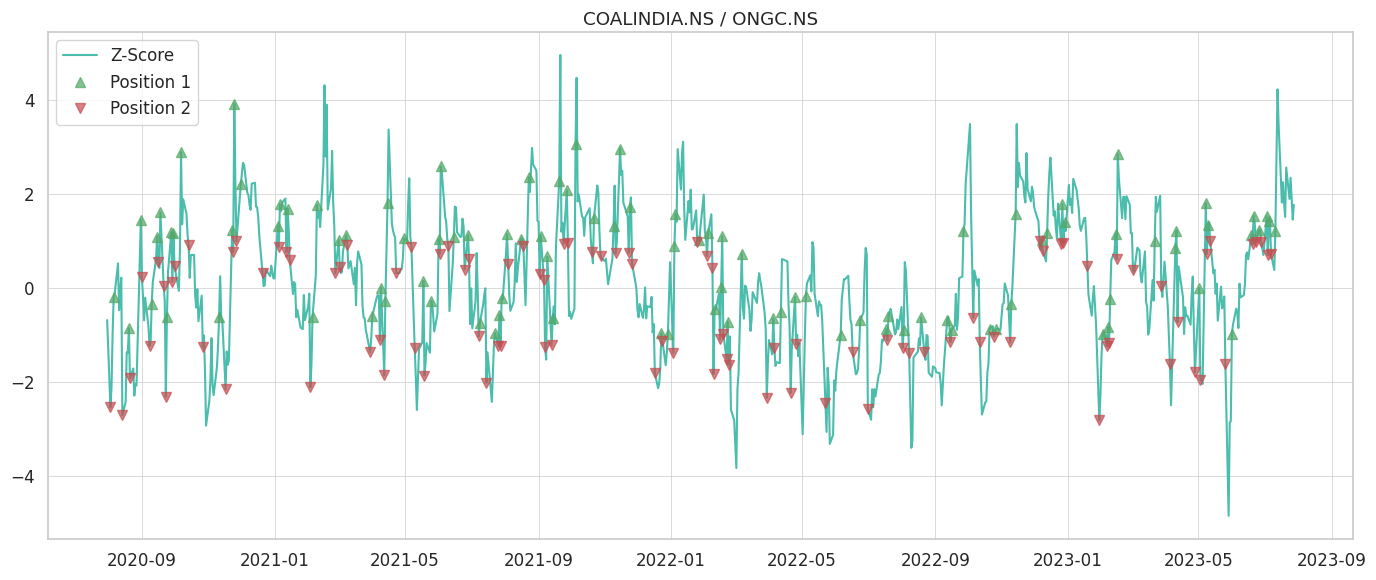

In [23]:
fig = plt.figure(figsize=(14, 6))
bx = fig.add_subplot(111)
series = bx.plot(signals['zscore'], c='#4abdac')
a = (signals['position1'] == 1) | (signals['position1'] == 2)
b = (signals['position1'] == -1) | (signals['position1'] == -2)
long = bx.plot(signals['zscore'][a], lw = 0, marker = '^', markersize = 7, c = 'g', alpha = 0.7)
short = bx.plot(signals['zscore'][b], lw = 0, marker = 'v', markersize = 7, c = 'r', alpha = 0.7)
plt.title(f'{stock1} / {stock2}')
plt.legend(['Z-Score', 'Position 1', 'Position 2'])
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

Position 1 --  Buy COALINDIA.NS and Sell ONGC.NS <br>
Position 2 -- Sell COALINDIA.NS and Buy ONGC.NS

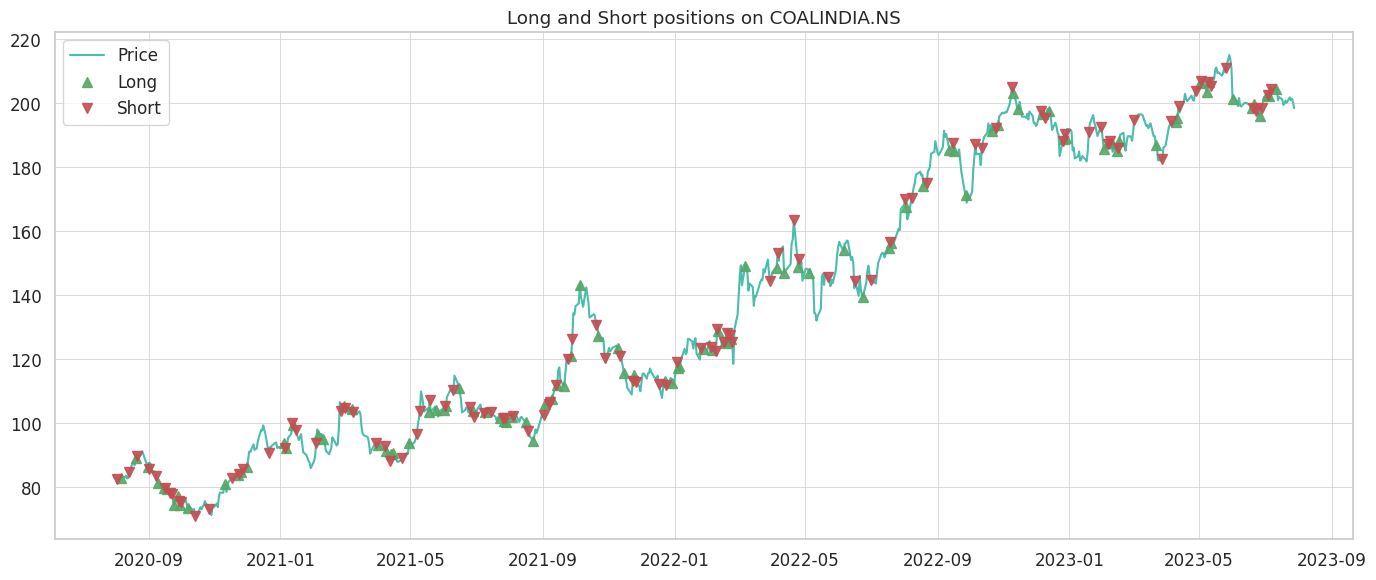

In [24]:
fig = plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)
l1 = bx.plot(signals[stock1], c='#4abdac')
u1 = bx.plot(signals[stock1][a], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
u2, = bx.plot(signals[stock1][b], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
plt.title('Long and Short positions on '+ str(stock1))
plt.legend(['Price', 'Long', 'Short'])
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

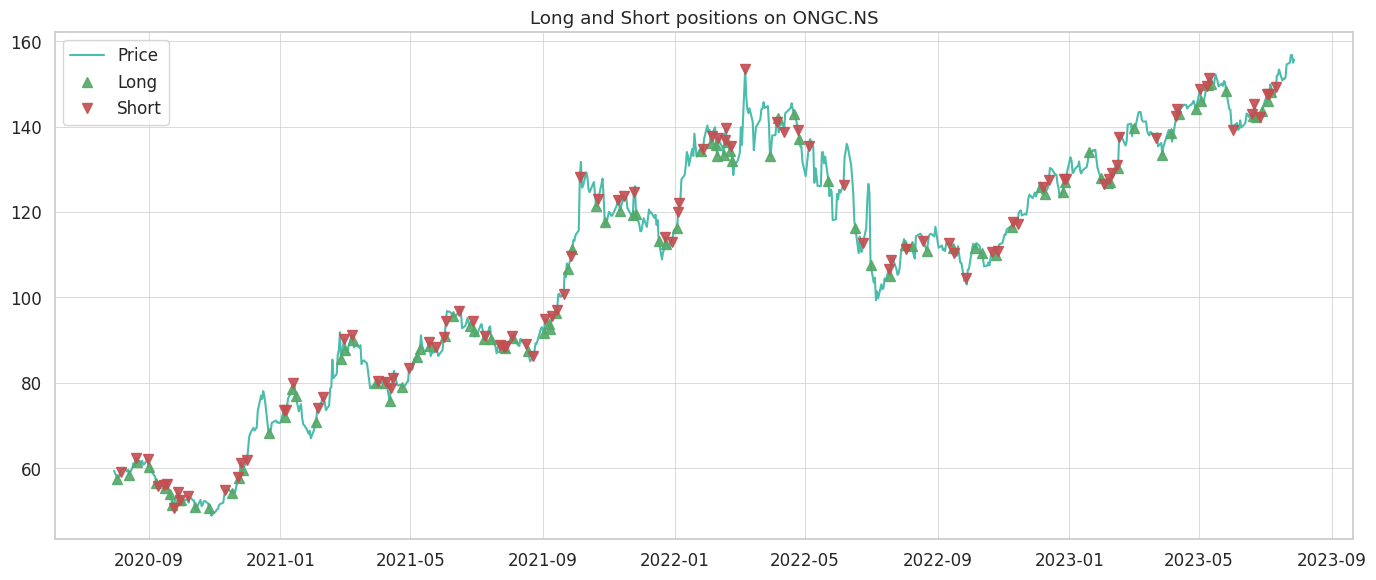

In [25]:
fig = plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)
l1 = bx.plot(signals[stock2], c='#4abdac')
u1 = bx.plot(signals[stock2][b], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
u2, = bx.plot(signals[stock2][a], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
plt.title('Long and Short positions on '+ str(stock2))
plt.legend(['Price', 'Long', 'Short'])
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

### <font color='black'>Visualising daily closing prices on backtesting period

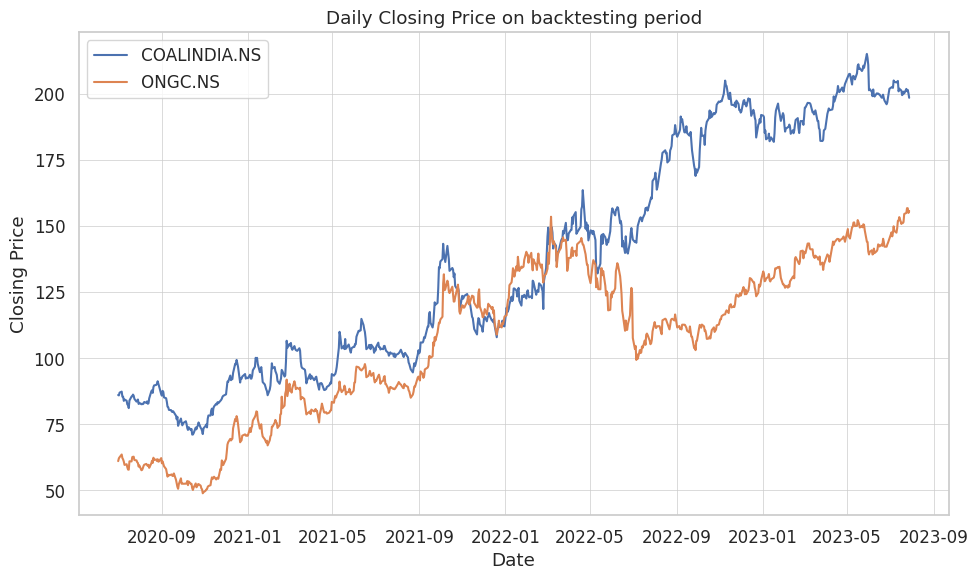

In [26]:
sns.lineplot(stockprices[stock1], label=stock1)
sns.lineplot(stockprices[stock2], label=stock2)
plt.title('Daily Closing Price on backtesting period')
plt.ylabel('Closing Price')
plt.xlabel('Date')
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

### <font color='black'>Generating Portfolio

In [27]:
initial_capital = 100000

w1 = 0.5
w2 = 1 - w1

# Shares to buy for each stock
shares1 = (w1*initial_capital)// (signals[stock1][0])
shares2 = (w2*initial_capital)// (signals[stock2][0])

#PnL for stock 1
portfolio = pd.DataFrame()
portfolio['holdings1'] = signals['position1'].cumsum() * signals[stock1] * shares1
portfolio['cash1'] = w1*initial_capital - (signals['position1'] * signals[stock1] * shares1).cumsum()
portfolio['total1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total1'].pct_change()

# PnL for stock 2
portfolio['holdings2'] = signals['position2'].cumsum() * signals[stock2] * shares2
portfolio['cash2'] = w2*initial_capital - (signals['position2'] * signals[stock2] * shares2).cumsum()
portfolio['total2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total2'].pct_change()

# Total PnL
portfolio['total'] = portfolio['total1'] + portfolio['total2']
portfolio = portfolio.dropna()

In [28]:
portfolio

,holdings1,cash1,total1,return1,holdings2,cash2,total2,return2,total
Date,,,,,,,,,
2020-08-03,-49603.908607,99603.908607,50000.000000,0.000000,48417.592052,1582.407948,50000.000000,0.000000,100000.000000
2020-08-04,-49739.123520,99603.908607,49864.785088,-0.002704,48545.177383,1582.407948,50127.585331,0.002552,99992.370419
2020-08-05,-49623.221748,99603.908607,49980.686859,0.002324,49087.401405,1582.407948,50669.809353,0.010817,100650.496212
2020-08-06,0.000000,49826.145050,49826.145050,-0.003092,0.000000,51371.511028,51371.511028,0.013849,101197.656078
2020-08-07,0.000000,49826.145050,49826.145050,0.000000,0.000000,51371.511028,51371.511028,0.000000,101197.656078
...,...,...,...,...,...,...,...,...,...
2023-07-24,121339.438629,-58409.428375,62930.010254,0.016549,-130318.426971,232797.290230,102478.863258,-0.003335,165408.873512
2023-07-25,120814.058838,-58409.428375,62404.630463,-0.008349,-131842.623978,232797.290230,100954.666252,-0.014873,163359.296715
2023-07-26,121103.022308,-58409.428375,62693.593933,0.004630,-131804.511032,232797.290230,100992.779198,0.000378,163686.373131


### <font color='black'>Visualizing Portfolio PnL

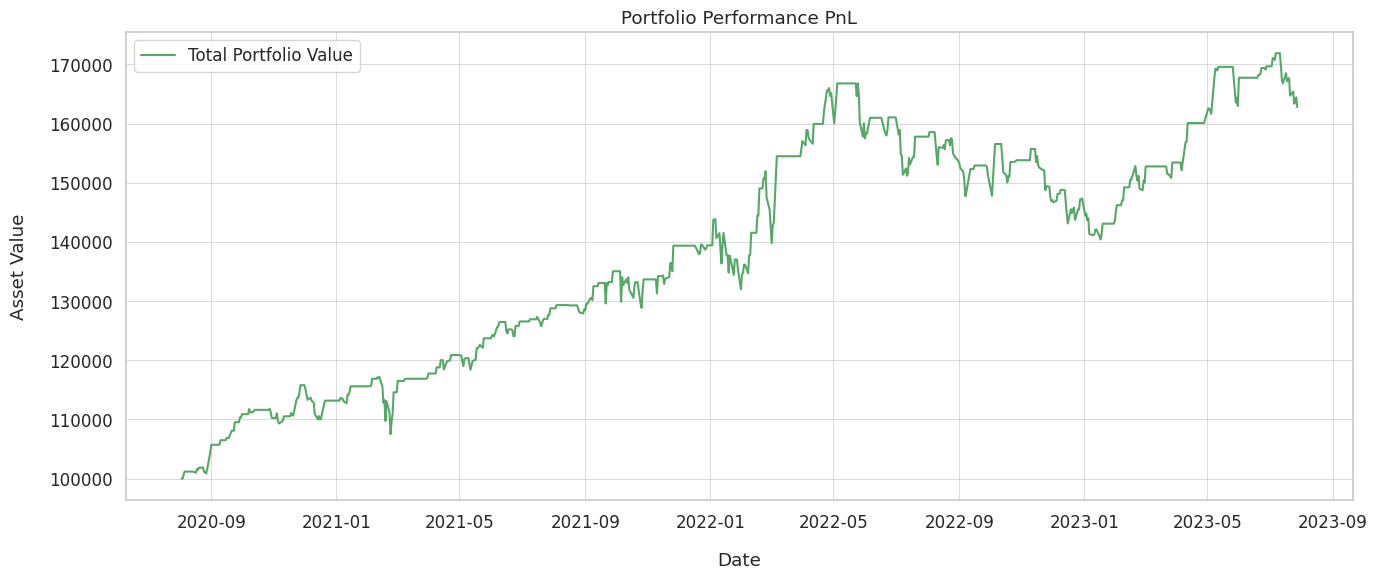

In [29]:
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
l1, = ax.plot(portfolio['total'], c='g')
ax.set_ylabel('Asset Value')
ax.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance PnL')
plt.legend(['Total Portfolio Value'])
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

### <font color='black'>Performance Metrics of Trading Strategy on Selected Pair of Stocks

In [30]:
final_portfolio = portfolio['total'].iloc[-1]
initial_portfolio = portfolio['total'].iloc[0]
delta = len(portfolio.index)
print('Number of trading days = ', delta)
YEAR_DAYS = 252
returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

Number of trading days =  744
CAGR = 17.942%


In [31]:
cummulative_return = (final_portfolio/initial_portfolio)-1
print('Cummulative Return = {:.3f}%' .format(cummulative_return * 100))

Cummulative Return = 62.776%


In [32]:
drawdown = qs.stats.max_drawdown(portfolio['total'])
print("Maximmum Drawdown of trading strategy:", np.round(drawdown*100, 3), "%")

Maximmum Drawdown of trading strategy: -15.809 %


In [33]:
sharpe_ratio = qs.stats.sharpe(portfolio['total'])
print("Sharpe Ratio:", np.round(sharpe_ratio, 3))

Sharpe Ratio: 1.165


In [ ]:
print('Frequency of trades:', np.round(abs(signals['position1']).sum()/len(portfolio)*252, 3), 'per year')